In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mplc
import pysal as ps
from shapely import geometry as sgeom
import descartes as des
import minbc
import numpy as np
import itertools as it
import copy
import decimal as dec
from pysal.cg import get_angle_between, Ray
from warnings import warn as Warn
from math import pi as PI
from scipy.spatial import distance as dist
%matplotlib inline

In [24]:
#data = ps.pdio.read_files('../../cdgeoms/all/districts001.dbf')
data = ps.pdio.read_files(ps.examples.get_path('columbus.shp'))

In [25]:
chains = data['geometry']
chain = chains[2]

In [26]:
pts = np.array([pt for part in chain.parts for pt in part])

pts_ch = list(reversed((pts[minbc.ConvexHull(pts).vertices]).tolist()))

points = pts_ch
POINTS = copy.deepcopy(points)
removed = []

def nples(l, n=3):
    cyc = it.cycle(l)
    previous = [l[-i] for i in range(1,n)]
    while cyc:
        current = next(cyc)
        yield [current] + previous
        previous = [current] + previous[:-1]

def _circle(A,B,C):
    """
    Returns (radius, (center_x, center_y)) of the circumscribed circle by the
    triangle pqr.

    note, this does not assume that p!=q!=r
    """
    Ax,Ay = dec.Decimal(A[0]), dec.Decimal(A[1])
    Bx,By = dec.Decimal(B[0]), dec.Decimal(B[1])
    Cx,Cy = dec.Decimal(C[0]), dec.Decimal(C[1])
    if np.array_equal([Ax,Ay], [Bx,By]) or np.array_equal([Bx,By],[Cx,Cy]):
        Warn('Duplicate neighboring point detected!')
    elif np.abs(_angle(A,B,C)) == 0:
        print('angle close to zero')
        radii = dist.euclidean(A,B)/2.
        center_x = float(Ax + Bx)/2.
        center_y = float(Ay + By)/2.
        return radii, (center_x, center_y)
    else:
        try:
            D = 2*(Ax*(By - Cy) + Bx*(Cy - Ay) + Cx*(Ay - By))
            center_x = float(((Ax**2 + Ay**2)*(By-Cy) + (Bx**2 + By**2)*(Cy-Ay) + (Cx**2 + Cy**2)*(Ay-By)) / D)
            center_y = float(((Ax**2 + Ay**2)*(Cx-Bx) + (Bx**2 + By**2)*(Ax-Cx) + (Cx**2 + Cy**2)*(Bx-Ax)) / D)
            radii = [dist.euclidean((center_x, center_y), pt) for pt in [A,B,C]]
        except dec.InvalidOperation:
            center_x = center_y = radii = -np.inf
        return radii, (center_x, center_y)

def _angle(p,q,r):
    """
    compute the positive angle formed by PQR
    """
    return np.abs(get_angle_between(Ray(q,p),Ray(q,r)))

([0.3868230100934605, 0.3868230100934603, 0.3868230100934601], (8.998565899671354, 13.833656681287298))


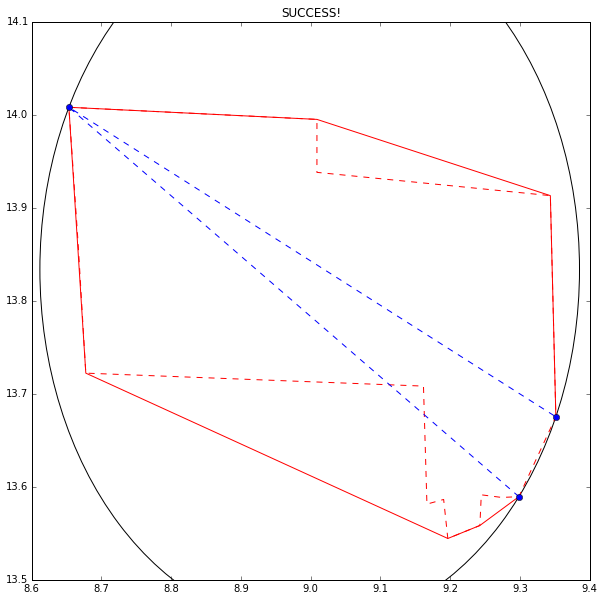

In [32]:
triple = nples(points)

angles = [_angle(*next(triple)) for p in points]

circles = [_circle(*next(triple)) for p in points]

radii = [np.max(c[0]) for c in circles]

lexord = np.lexsort((angles, radii))
lexmax = lexord[-1] #recall, we're addressing p, previous_p, two_before_p

#lexord = np.lexsort((radii, angles))
#lexmax = lexord[-1]

print(circles[lexmax])


#recall the triple generator is in leading-index order.
candidate = points[lexmax], points[lexmax-1], points[lexmax-2]
#print(_circle(*candidate))
fig = plt.figure(figsize=(10,10))
plt.plot([p[0] for p in POINTS], [p[-1] for p in POINTS], 'r')
plt.plot([p[0] for p in pts], [p[-1] for p in pts], 'r--')
plt.plot([p[0] for p in points], [p[-1] for p in points], 'b--')
plt.plot([c[0] for c in candidate], [c[1] for c in candidate], 'bo')
#circplots = [plt.Circle(x[-1], x[0], fc='white') for x in circles]
#for c in circplots:
#    fig.gca().add_artist(c)
fig.gca().add_artist(plt.Circle(circles[lexmax][-1], radii[lexmax], fc='w'))
if angles[lexmax] > PI/2:
    plt.title('FAILURE')
    removed = points.pop(lexmax-1)
    plt.plot(removed[0], removed[1], 'kx')
else:
    plt.title('SUCCESS!')
plt.show()

### Cool. How fast is this?

In [ ]:
import time

In [ ]:
def demo_mbc(chains):
    for cidx, chain in enumerate(chains):
        points = chain
        start = time.time()
        (radius, center), inset, removed, constraints = cent.skyum(chain)
        elapsed = time.time() - start
        mbc_poly = sgeom.Point(*center).buffer(radius)
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        parray = ps.common.np.array(points)
        ax.set_xlim(parray[:,0].min()*.98, parray[:,0].max()*1.02)
        ax.set_ylim(parray[:,1].min()*.98, parray[:,1].max()*1.02)
        ax.plot([p[0] for p in points], [p[-1] for p in points], 'r')
        ax.add_patch(des.PolygonPatch(mbc_poly, fc='white', ec='black'))
        chull = cent.hull(points)
        #ax.plot([p[0] for p in chull], [p[-1] for p in chull], '--m')
        ax.plot([p[0] for p in constraints], [p[-1] for p in constraints], '^b')
        #ax.plot([p[0] for p in inset], [p[-1] for p in inset], 'ob')
        ax.plot([p[0][0] for p in removed[:-1]], [p[0][1] for p in removed[:-1]], 'xc')
        ax.plot(removed[-1][0][0], removed[-1][0][1], '*k')
        plt.title('Shape #{}, Elapsed Time: {}'.format(cidx, elapsed))
        #print(removed)
        nonboundary = [p for p in chull.tolist() if p not in constraints]
        succeeded = [mbc_poly.contains(sgeom.Point(p)) for p in nonboundary]
        for i,v in enumerate(succeeded):
            print("Point {i}: {tf}".format(i=i, tf=v))
            if not v:
                ax.plot(chull.tolist()[i][0], chull.tolist()[i][1], 'gH')
        plt.show()
        plt.clf()

In [ ]:
demo_mbc(chains)

In [ ]:
cent.hull(chains[8])

In [ ]:
plt.plot(*cent.hull(chains[8]).T.tolist())
plt.plot(*cent.hull(chains[8])[5].T.tolist(), 'ok')
plt.plot(*cent.hull(chains[8])[6].T.tolist(), 'ok')
plt.plot(*cent.hull(chains[8])[7].T.tolist(), 'ok')

In [ ]:
cent._circle(chains[8][-5], chains[8][-4], chains[8][-3])